In [ ]:
!pip install fbprophet

In [ ]:
#import necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import io
from google.colab import files
plt.style.use('ggplot')
import itertools
%matplotlib inline
import plotly.offline as pyoff
import plotly.graph_objs as go
from math import sqrt
from sklearn import preprocessing
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [ ]:
train_df = pd.read_csv('/content/train.csv')

In [ ]:
train_df['periode'] = pd.to_datetime(train_df['periode'])
print(train_df.iloc[:3, :3])
print()
print(train_df.iloc[-3:, :3])

     periode  cash_in_echannel  cash_out_echannel
0 2019-07-31      7.303000e+08      -1.304400e+09
1 2019-08-01      7.322000e+08      -8.321500e+08
2 2019-08-02      1.169800e+09      -6.214000e+08

       periode  cash_in_echannel  cash_out_echannel
422 2020-09-28      7.438000e+08       -556200000.0
423 2020-09-29      1.009250e+09       -772100000.0
424 2020-09-30      6.861000e+08       -833250000.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   periode                     425 non-null    datetime64[ns]
 1   cash_in_echannel            425 non-null    float64       
 2   cash_out_echannel           425 non-null    float64       
 3   cash_in_kantor              425 non-null    float64       
 4   cash_out_kantor             425 non-null    float64       
 5   cr_ketetapan_total_bkn_sum  425 non-null    float64       
 6   giro                        425 non-null    float64       
 7   deposito                    425 non-null    float64       
 8   kewajiban_lain              425 non-null    float64       
 9   tabungan                    425 non-null    float64       
 10  rata_dpk_mingguan           425 non-null    float64       
 11  kas_kantor                  425 non-null    float64       

In [ ]:
train_df.describe()

,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
count,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,425.0,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02
mean,7.033414e+08,-6.992033e+08,8.977969e+10,-6.286235e+10,3.0,8.812831e+11,9.006301e+11,1.376502e+10,6.781954e+11,3.092173e+11,5.749233e+12,3.755702e+09
std,3.421859e+08,3.735076e+08,9.260369e+10,5.224739e+10,0.0,3.866041e+11,1.915942e+11,3.401930e+09,1.093638e+11,3.761426e+10,3.252305e+12,1.024274e+09
min,0.000000e+00,-2.670100e+09,0.000000e+00,-3.447494e+11,3.0,3.820936e+11,7.293214e+11,1.008030e+10,6.170567e+11,2.544115e+11,1.928940e+09,1.834650e+09
25%,4.731000e+08,-8.321500e+08,0.000000e+00,-9.581374e+10,3.0,6.132331e+11,8.071794e+11,1.172827e+10,6.432508e+11,2.801590e+11,2.992979e+12,3.093200e+09
50%,6.357000e+08,-6.359000e+08,7.930647e+10,-6.712278e+10,3.0,8.192550e+11,8.559837e+11,1.281586e+10,6.670075e+11,3.061373e+11,5.488568e+12,3.533750e+09
75%,8.567000e+08,-4.792500e+08,1.264345e+11,0.000000e+00,3.0,1.027486e+12,9.102288e+11,1.521910e+10,6.962898e+11,3.306770e+11,8.453749e+12,4.087700e+09
max,3.744400e+09,0.000000e+00,6.569255e+11,0.000000e+00,3.0,4.678342e+12,3.464395e+12,4.759059e+10,2.794601e+12,4.516209e+11,1.140874e+13,9.070650e+09


In [ ]:
train_df_kantor = train_df.copy()
train_df_kantor.rename(columns = {'periode':'ds', 'kas_kantor':'y'}, inplace = True)

In [ ]:
train_df_kantor.head()

,ds,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,y,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


In [ ]:
train_df_masuk_kantor = train_df.copy()
train_df_masuk_kantor.rename(columns = {'periode':'ds', 'cash_in_kantor':'y'}, inplace = True)
train_df_keluar_kantor = train_df.copy()
train_df_keluar_kantor.rename(columns = {'periode':'ds', 'cash_out_kantor':'y'}, inplace = True)

In [ ]:
train_df_masuk_channel = train_df.copy()
train_df_masuk_channel.rename(columns = {'periode':'ds', 'cash_in_echannel':'y'}, inplace = True)
train_df_keluar_channel = train_df.copy()
train_df_keluar_channel.rename(columns = {'periode':'ds', 'cash_out_echannel':'y'}, inplace = True)

In [ ]:
train_df_channel = train_df.copy()
train_df_channel.rename(columns = {'periode':'ds', 'kas_echannel':'y'}, inplace = True)

In [ ]:
train_df_channel.head()

,ds,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,y
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


In [ ]:
train_df_news = train_df.copy()
train_df_news = train_df_news.set_index('periode')

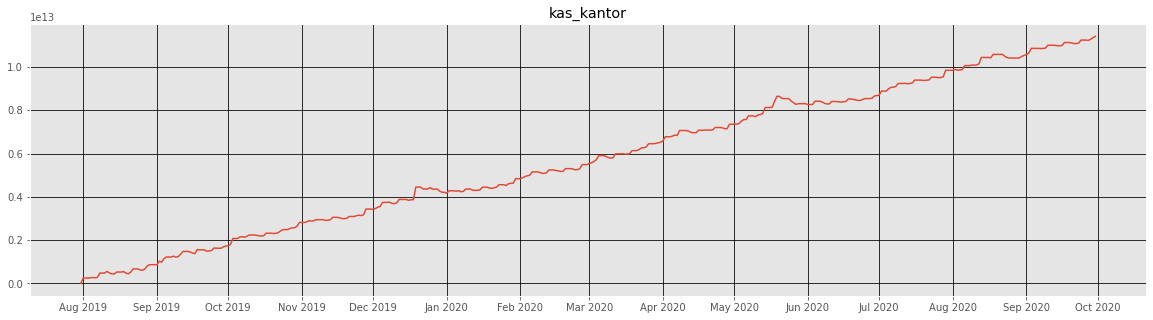

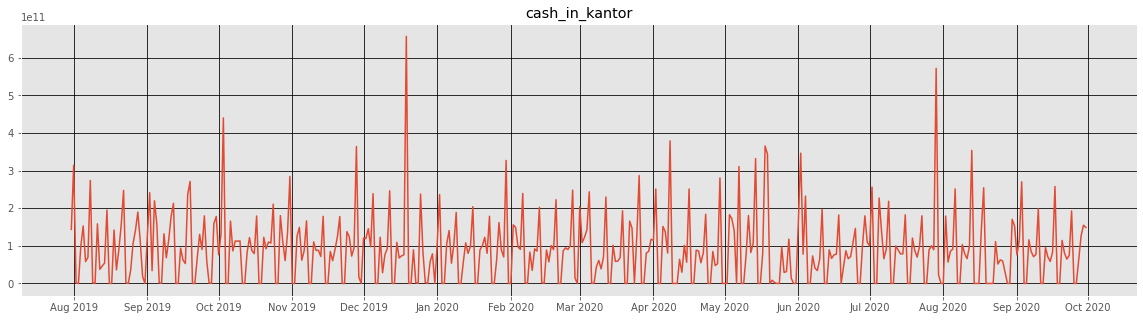

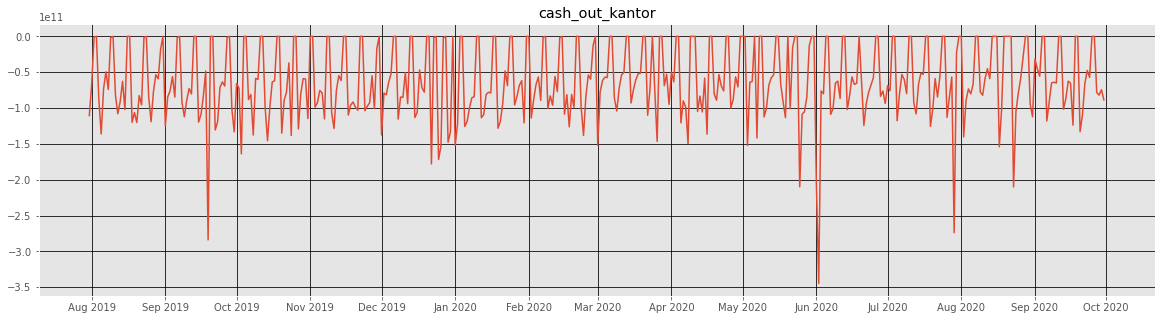

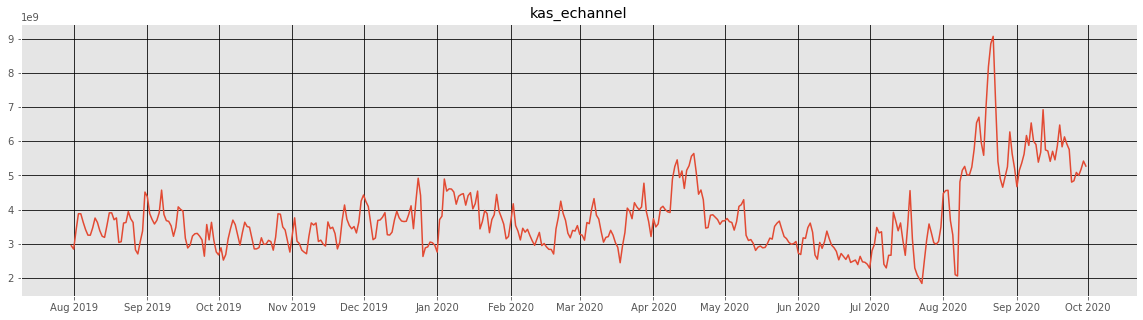

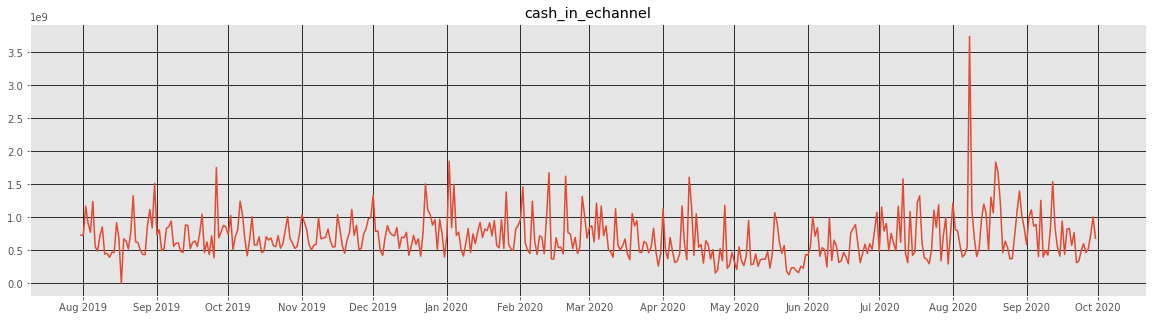

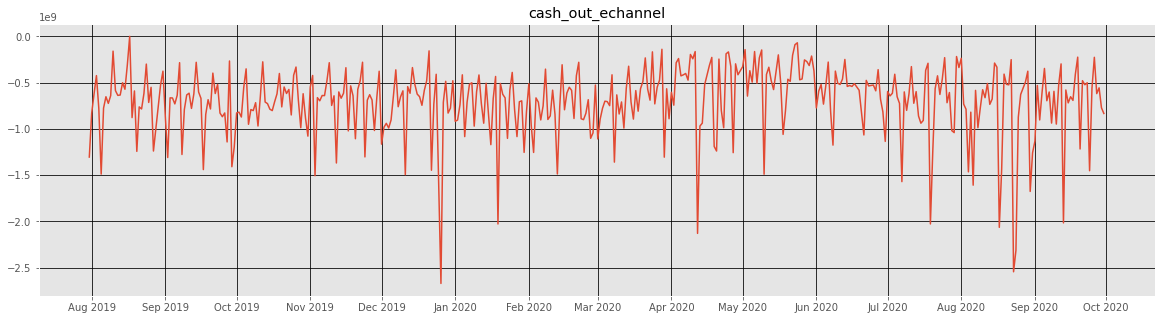

In [ ]:
import matplotlib.dates as mdates

important_cols = ['kas_kantor', 'cash_in_kantor', 'cash_out_kantor',
                  'kas_echannel', 'cash_in_echannel', 'cash_out_echannel']

for col in important_cols:
    plt.figure(figsize=(20, 5))
    plt.plot(train_df_news[col])
    plt.grid(color='black')
    plt.title(col)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.show()

In [ ]:
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['cash_in_kantor'], name='Kas Masuk Kantor',))
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['cash_out_kantor'], name='Kas Keluar Kantor',))
fig.show()

In [ ]:
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['cash_in_echannel'], name='Kas Masuk eChannel',))
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['cash_out_echannel'], name='Kas Keluar eChannel',))
fig.show()

In [ ]:
train_df['nilai_echannel'] = train_df['cash_in_echannel'] + train_df['cash_out_echannel']
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['nilai_echannel'], name='Kas Keluar Masuk eChannel',))
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['kas_echannel'], name='Kas eChannel',))
fig.show()

In [ ]:
train_df['nilai_kantor'] = train_df['cash_in_kantor'] + train_df['cash_out_kantor']
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['nilai_kantor'], name='Kas Keluar Masuk Kantor',))
fig.add_trace(go.Scatter(x=train_df['periode'], y=train_df['kas_kantor'], name='Kas Kantor',))
fig.show()

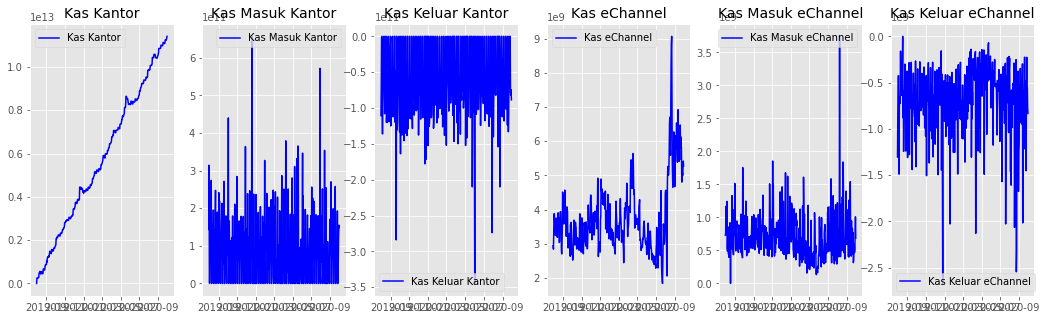

In [ ]:
#Setting the figure size
plt.rcParams["figure.figsize"] = (18,5)

#Subdividing the figure into 6 figures
fig, ax = plt.subplots(1,6)

#First Plot - Kas Kantor against time
ax[0].plot(train_df_news.kas_kantor, color="blue", label="Kas Kantor")
ax[0].set_title("Kas Kantor", size=14)
ax[0].legend()

#Second Plot - cash in kantor against time
ax[1].plot(train_df_news.cash_in_kantor, color="blue", label="Kas Masuk Kantor")
ax[1].set_title("Kas Masuk Kantor", size=14)
ax[1].legend()

#Third Plot - cash out kantor against time
ax[2].plot(train_df_news.cash_out_kantor, color="blue", label="Kas Keluar Kantor")
ax[2].set_title("Kas Keluar Kantor", size=14)
ax[2].legend()

#Fourth Plot - Kas eChannel against time
ax[3].plot(train_df_news.kas_echannel, color="blue", label="Kas eChannel")
ax[3].set_title("Kas eChannel", size=14)
ax[3].legend()

#Fifth Plot - cash in kantor against time
ax[4].plot(train_df_news.cash_in_echannel, color="blue", label="Kas Masuk eChannel")
ax[4].set_title("Kas Masuk eChannel", size=14)
ax[4].legend()

#Sixth Plot - cash out kantor against time
ax[5].plot(train_df_news.cash_out_echannel, color="blue", label="Kas Keluar eChannel")
ax[5].set_title("Kas Keluar eChannel", size=14)
ax[5].legend()

plt.show()

In [ ]:
train_df_train = train_df_news.loc[:"2020-09-30"]
train_df_test = train_df_news.loc["2020-10-01":]

print("Training Set Shape -", train_df_train.shape)
print("Test Set Shape -", train_df_test.shape)

Training Set Shape - (425, 12)
Test Set Shape - (0, 12)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when cr

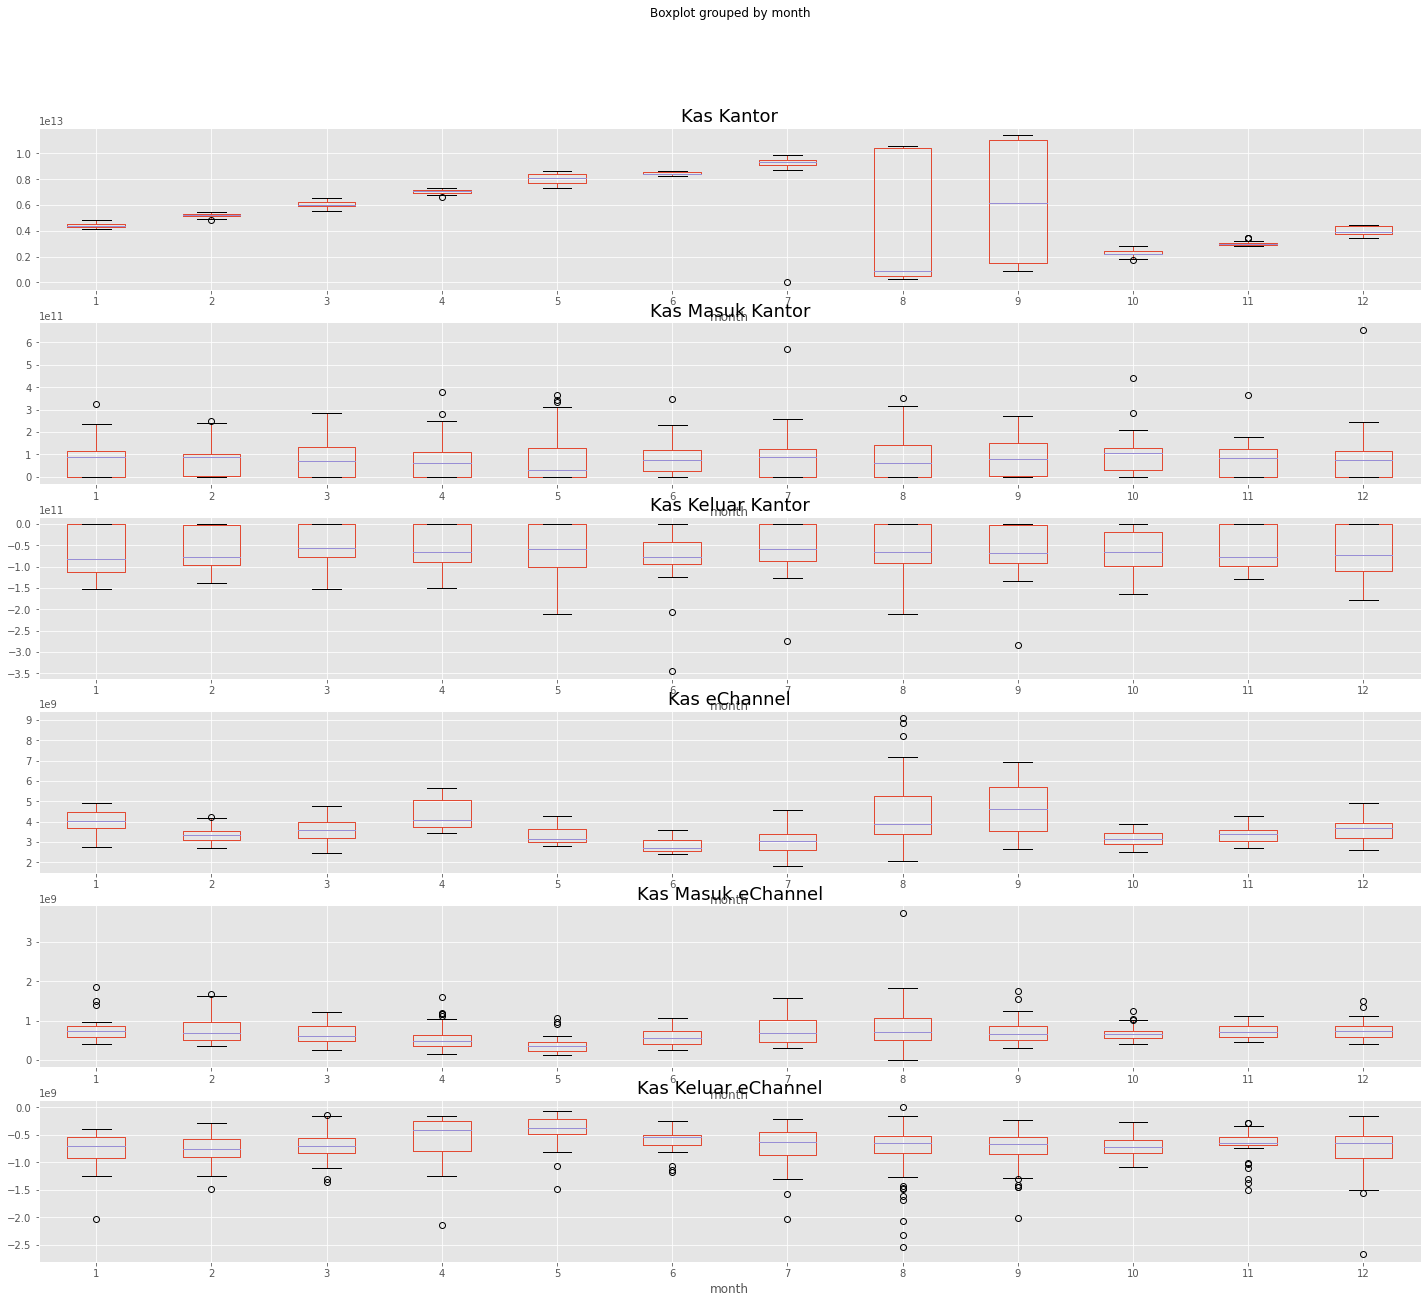

In [ ]:
#Adding another column in training 
train_df_train["month"] = train_df_train.index.month

#setting the size of the figure
plt.rcParams["figure.figsize"] = 24,21

#defining 6 subplots
fig, axes = plt.subplots(6, 1)

#First Boxplot: Kas Kantor
train_df_train.boxplot(by='month', column=['kas_kantor'], ax = axes[0])
axes[0].set_title("Kas Kantor", size=18)

#First Boxplot: Kas Kantor
train_df_train.boxplot(by='month', column=['cash_in_kantor'], ax = axes[1])
axes[1].set_title("Kas Masuk Kantor", size=18)

#First Boxplot: Kas Kantor
train_df_train.boxplot(by='month', column=['cash_out_kantor'], ax = axes[2])
axes[2].set_title("Kas Keluar Kantor", size=18)

#First Boxplot: Kas Kantor
train_df_train.boxplot(by='month', column=['kas_echannel'], ax = axes[3])
axes[3].set_title("Kas eChannel", size=18)

#First Boxplot: Kas Kantor
train_df_train.boxplot(by='month', column=['cash_in_echannel'], ax = axes[4])
axes[4].set_title("Kas Masuk eChannel", size=18)

#First Boxplot: Kas Kantor
train_df_train.boxplot(by='month', column=['cash_out_echannel'], ax = axes[5])
axes[5].set_title("Kas Keluar eChannel", size=18)

plt.show()

In [ ]:
# Apply Box-Cox Transform and save the lambda for later inverse.
train_df_kantor['y'], lam = boxcox(train_df_kantor['y'])
print('Lambda is:', lam)

Lambda is: 0.7058801187952178


In [ ]:
# Apply Box-Cox Transform and save the lambda for later inverse.
train_df_channel['y'], lam2 = boxcox(train_df_channel['y'])
print('Lambda is:', lam2)

Lambda is: -0.7870607029283726


In [ ]:
# normalize data
scaler = preprocessing.MinMaxScaler()
train_df_norm = scaler.fit_transform(train_df_news)
train_df_norm = pd.DataFrame(train_df_norm,columns=train_df_news.columns, index=train_df_news.index)
train_df_norm.reset_index(inplace=True)
train_df_norm.rename(columns = {'periode':'ds', 'kas_kantor':'y1', 
                              'kas_echannel':'y2'}, inplace = True)
train_df_norm.head()

,ds,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,y1,y2
0,2019-07-31,0.195038,0.511479,0.218704,0.679157,0.0,0.140737,0.027602,0.109745,0.041426,0.300001,0.000000,0.152633
1,2019-08-01,0.195545,0.688345,0.478613,0.805337,0.0,0.119675,0.030434,0.060259,0.038641,0.300001,0.021680,0.138820
2,2019-08-02,0.312413,0.767275,0.001905,0.996686,0.0,0.121938,0.030493,0.046385,0.034544,0.300001,0.021690,0.214608
3,2019-08-03,0.243951,0.841186,0.000000,1.000000,0.0,0.121878,0.030494,0.051082,0.031993,0.300001,0.021690,0.282242
4,2019-08-04,0.207043,0.708644,0.150448,0.746794,0.0,0.138898,0.030401,0.059965,0.029523,0.300001,0.022702,0.281868


In [ ]:
# Hyperparameters
PERIODS = 31
FREQ = 'D'

# Forecasting
#m = Prophet()
#m = Prophet(yearly_seasonality=True,daily_seasonality=True, weekly_seasonality=True)
#m = Prophet(daily_seasonality=True, weekly_seasonality=True)
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
#m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.add_country_holidays(country_name='ID')
m.add_seasonality(name='halfday', period=0.5, fourier_order=1, prior_scale=0.05)
m.add_seasonality(name='halfweek', period=3.5, fourier_order=2, prior_scale=0.05)
m.add_seasonality(name='biweekly', period=14, fourier_order=4, prior_scale=0.05)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.05)
m.add_seasonality(name='bimonthly', period=61, fourier_order=5, prior_scale=0.05)
m.add_seasonality(name='quarterly', period=91.5, fourier_order=6, prior_scale=0.05)
m.add_seasonality(name='semester', period=183, fourier_order=7, prior_scale=0.05)
m.add_seasonality(name='cawu', period=122, fourier_order=6, prior_scale=0.05)
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(train_df_kantor)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



In [ ]:
display(train_df_kantor.tail())
display(forecast.tail())

,ds,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,y,kas_echannel
420,2020-09-26,4.692000e+08,-226400000.0,0.000000e+00,0.000000e+00,3.0,6.770562e+11,7.984164e+11,1.234267e+10,7.260305e+11,2.978684e+11,1.123736e+13,5.085800e+09
421,2020-09-27,5.272500e+08,-618750000.0,6.466720e+10,-7.829833e+10,3.0,8.005756e+11,7.979421e+11,1.226298e+10,7.243814e+11,2.978684e+11,1.122373e+13,4.994300e+09
422,2020-09-28,7.438000e+08,-556200000.0,1.264345e+11,-8.203374e+10,3.0,1.531154e+12,7.961238e+11,1.521195e+10,7.234264e+11,2.978684e+11,1.126813e+13,5.181900e+09
423,2020-09-29,1.009250e+09,-772100000.0,1.548627e+11,-7.443120e+10,3.0,8.638740e+11,7.731039e+11,1.320539e+10,7.201773e+11,2.978684e+11,1.134856e+13,5.419050e+09
424,2020-09-30,6.861000e+08,-833250000.0,1.487817e+11,-8.860700e+10,3.0,7.373418e+11,7.743742e+11,1.311528e+10,7.540607e+11,2.759476e+11,1.140874e+13,5.271900e+09


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension of Jesus,Ascension of Jesus_lower,Ascension of Jesus_upper,Ascension of the Prophet,Ascension of the Prophet_lower,Ascension of the Prophet_upper,Birth of the Prophet,Birth of the Prophet_lower,Birth of the Prophet_upper,Buddha's Birthday,Buddha's Birthday_lower,Buddha's Birthday_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Christmas,Christmas_lower,Christmas_upper,Day of Silence/ Nyepi,Day of Silence/ Nyepi_lower,Day of Silence/ Nyepi_upper,Eid al-Fitr,Eid al-Fitr_lower,Eid al-Fitr_upper,Feast of the Sacrifice,Feast of the Sacrifice_lower,Feast of the Sacrifice_upper,Independence Day,Independence Day_lower,Independence Day_upper,Islamic New Year,Islamic New Year_lower,Islamic New Year_upper,Labor Day,...,additive_terms,additive_terms_lower,additive_terms_upper,bimonthly,bimonthly_lower,bimonthly_upper,biweekly,biweekly_lower,biweekly_upper,cawu,cawu_lower,cawu_upper,halfday,halfday_lower,halfday_upper,halfweek,halfweek_lower,halfweek_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,quarterly,quarterly_lower,quarterly_upper,semester,semester_lower,semester_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
451,2020-10-27,1.202331e+13,1.203219e+13,1.217147e+13,1.202139e+13,1.202557e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.891020e+10,7.891020e+10,7.891020e+10,-1.342289e+11,-1.342289e+11,-1.342289e+11,-2.008919e+10,-2.008919e+10,-2.008919e+10,1.949058e+11,1.949058e+11,1.949058e+11,5.457156e+09,5.457156e+09,5.457156e+09,-5.819917e+08,-5.819917e+08,-5.819917e+08,0.000000e+00,0.000000e+00,0.000000e+00,-2.245964e+10,-2.245964e+10,-2.245964e+10,-3.180100e+10,-3.180100e+10,-3.180100e+10,1.381758e+11,1.381758e+11,1.381758e+11,-3.534597e+10,-3.534597e+10,-3.534597e+10,-1.512184e+10,-1.512184e+10,-1.512184e+10,0.0,0.0,0.0,1.210222e+13
452,2020-10-28,1.204881e+13,1.209698e+13,1.223803e+13,1.204677e+13,1.205120e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.148890e+11,1.148890e+11,1.148890e+11,-1.520765e+11,-1.520765e+11,-1.520765e+11,-1.473193e+10,-1.473193e+10,-1.473193e+10,2.084350e+11,2.084350e+11,2.084350e+11,5.457156e+09,5.457156e+09,5.457156e+09,-5.655726e+09,-5.655726e+09,-5.655726e+09,0.000000e+00,0.000000e+00,0.000000e+00,-1.592779e+10,-1.592779e+10,-1.592779e+10,-1.253704e+10,-1.253704e+10,-1.253704e+10,1.105707e+11,1.105707e+11,1.105707e+11,-2.284663e+10,-2.284663e+10,-2.284663e+10,1.420182e+10,1.420182e+10,1.420182e+10,0.0,0.0,0.0,1.216370e+13
453,2020-10-29,1.207432e+13,1.232316e+13,1.246066e+13,1.207212e+13,1.207688e+13,0.0,0.0,0.0,0.0,0.0,0.0,7.052394e+10,7.052394e+10,7.052394e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.191985e+11,3.191985e+11,3.191985e+11,-1.639362e+11,-1.639362e+11,-1.639362e+11,3.763106e+09,3.763106e+09,3.763106e+09,2.192102e+11,2.192102e+11,2.192102e+11,5.457156e+09,5.457156e+09,5.457156e+09,7.359120e+09,7.359120e+09,7.359120e+09,7.052394e+10,7.052394e+10,7.052394e+10,-6.667025e+09,-6.667025e+09,-6.667025e+09,7.399787e+09,7.399787e+09,7.399787e+09,8.007680e+10,8.007680e+10,8.007680e+10,5.091468e+10,5.091468e+10,5.091468e+10,4.509696e+10,4.509696e+10,4.509696e+10,0.0,0.0,0.0,1.239352e+13
454,2020-10-30,1.209982e+13,1.227659e+13,1.241657e+13,1.209746e+13,1.210256e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.491228e+11,2.491228e+11,2.491228e+11,-1.696832e+11,-1.696832e+11,-1.696832e+11,6.587463e+09,6.587463e+09,6.587463e+09,2.264242e+11,2.264242

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



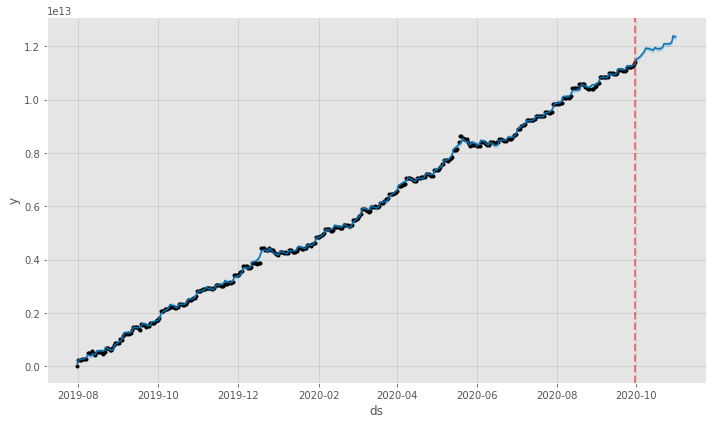

In [ ]:
# Plotting with Prophet built-in method
fig = m.plot(forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('31 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



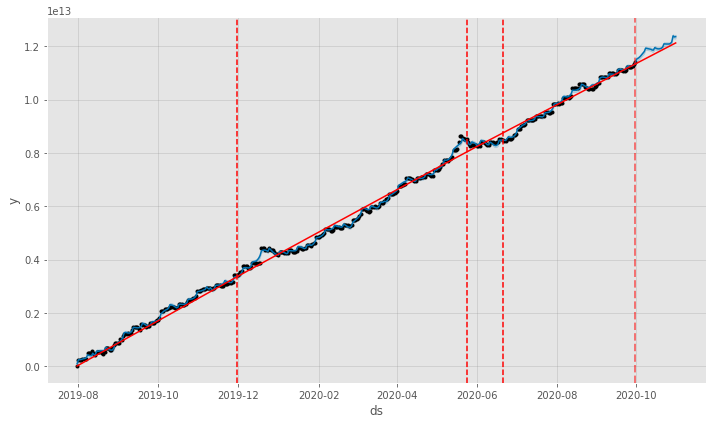

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('31 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [ ]:
# Listing all the change points in the model
deltas = m.params['delta'].mean(0)
cp = pd.DataFrame(m.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6

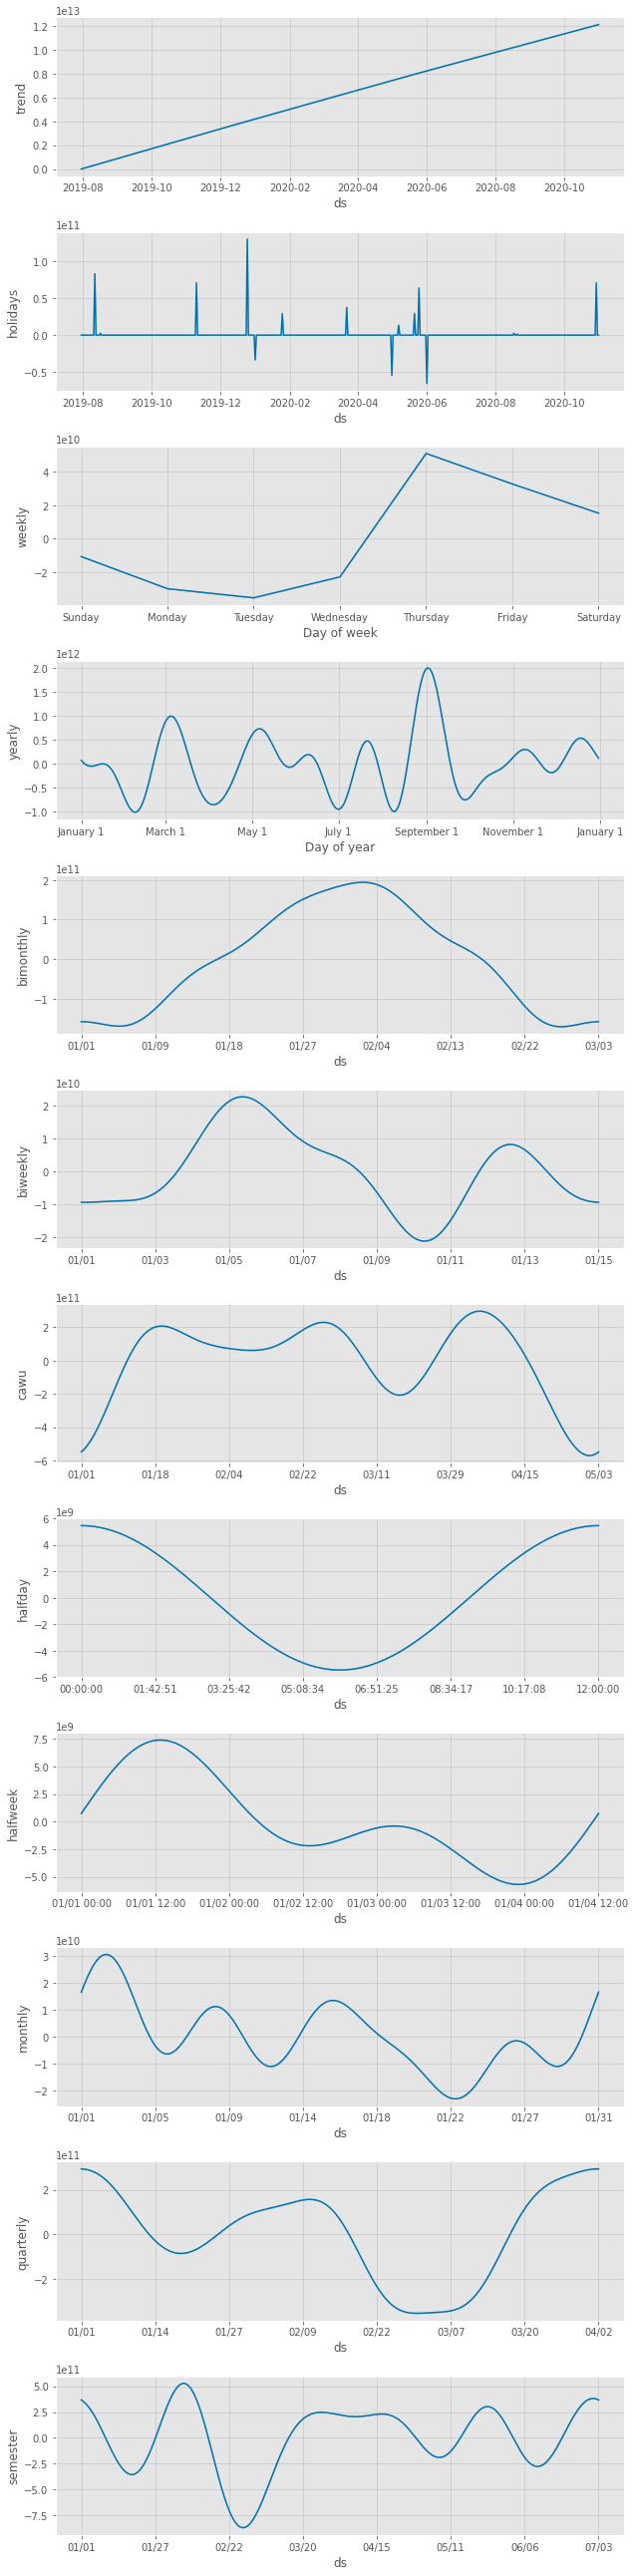

In [ ]:
fig = m.plot_components(forecast)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



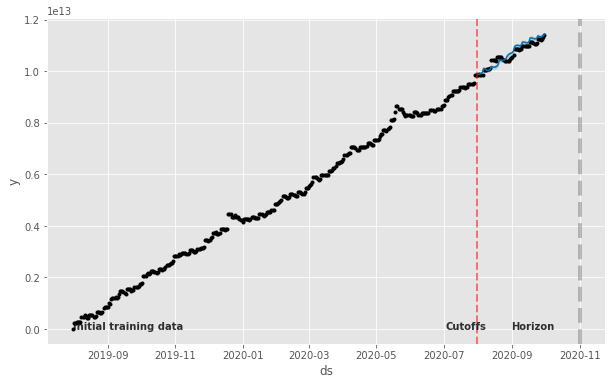

In [ ]:
# Fit the model with one year of data and define a horizon of 31 days forcasting per quarter
df_cv = cross_validation(m, initial='366 days', period = '30.5 days', horizon = '61 days')

cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2019-07-31'),y=12, s='Initial training data', color='black',
       fontsize=10, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2020-07-02'),y=24, s='Cutoffs', color='black',
       fontsize=10, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('31 days'),y=24, s='Horizon', color='black',
       fontsize=10, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('93 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-01,9.888962e+12,9.821765e+12,9.957998e+12,9.842415e+12,2020-07-31
1,2020-08-02,9.895628e+12,9.829458e+12,9.959813e+12,9.881275e+12,2020-07-31
2,2020-08-03,9.906442e+12,9.837320e+12,9.972823e+12,9.848523e+12,2020-07-31
3,2020-08-04,9.923685e+12,9.855752e+12,9.992555e+12,9.860673e+12,2020-07-31
4,2020-08-05,9.984133e+12,9.920591e+12,1.004875e+13,9.871698e+12,2020-07-31


In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,4.315681e+21,6.569384e+10,5.898136e+10,0.005962,0.005905,0.833333
1,7 days,4.300519e+21,6.557834e+10,5.881674e+10,0.005929,0.005905,0.833333
2,8 days,4.288280e+21,6.548496e+10,5.834365e+10,0.005877,0.005905,0.833333
3,9 days,4.043020e+21,6.358475e+10,5.592283e+10,0.005615,0.005230,0.833333
4,10 days,3.687277e+21,6.072295e+10,5.256234e+10,0.005258,0.004417,0.833333


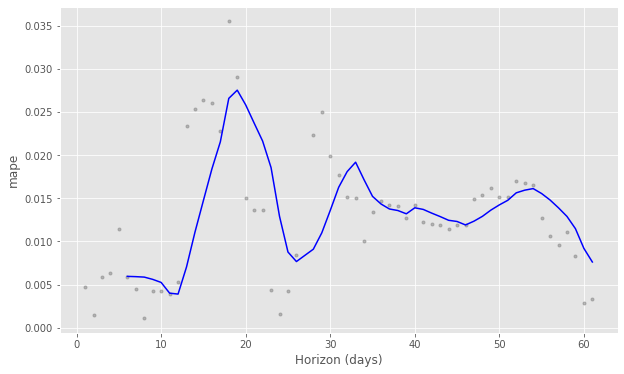

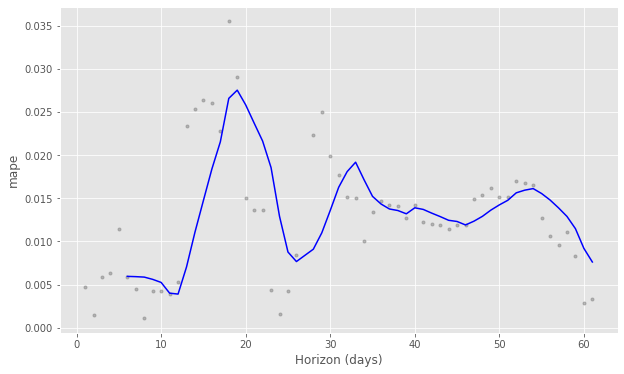

In [ ]:
plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
df_p.mean()

horizon     33 days 14:50:10.909090909
mse                        2.71062e+22
rmse                        1.5439e+11
mae                        1.45633e+11
mape                         0.0136107
mdape                        0.0134261
coverage                      0.221212
dtype: object

In [ ]:
from sklearn.metrics import mean_squared_log_error
rmsle_kantor = sqrt(mean_squared_log_error(df_cv[['y']],df_cv[['yhat']]))
print("RMSLE Kas Kantor adalah",rmsle_kantor)

RMSLE Kas Kantor adalah 0.00022192535697810472


In [ ]:
forecast[['ds','yhat']].to_csv('submission_kantor.csv')

In [ ]:
# Hyperparameters
PERIODS = 31
FREQ = 'D'

# Forecasting
#m = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=True)
#m = Prophet()
#m = Prophet(daily_seasonality=True)
m = Prophet(yearly_seasonality=True)
#m = Prophet(weekly_seasonality=True)
#m = Prophet(yearly_seasonality=True, daily_seasonality=True)
#m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_country_holidays(country_name='ID')
m.add_seasonality(name='halfday', period=0.5, fourier_order=1, prior_scale=0.05)
#m.add_seasonality(name='2day', period=2, fourier_order=2, prior_scale=0.05)
m.add_seasonality(name='halfweek', period=3.5, fourier_order=2, prior_scale=0.05)
#m.add_seasonality(name='biweekly', period=15.25, fourier_order=4, prior_scale=0.05)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.05)
#m.add_seasonality(name='bimonthly', period=61, fourier_order=5, prior_scale=0.05)
m.add_seasonality(name='halfquarterly', period=45.75, fourier_order=5, prior_scale=0.05)
#m.add_seasonality(name='quarterly', period=91.5, fourier_order=6, prior_scale=0.05)
#m.add_seasonality(name='semester', period=183, fourier_order=7, prior_scale=0.05)
m.add_seasonality(name='cawu', period=122, fourier_order=6, prior_scale=0.05)
#m.add_seasonality(name='cawu2', period=244, fourier_order=8, prior_scale=0.05)
m.add_seasonality(name='fullrange', period=427, fourier_order=10, prior_scale=0.05)
m.add_seasonality(name='halfrange', period=213.5, fourier_order=7, prior_scale=0.05)

# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(train_df_channel)
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future1 = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
#future1 = future1.merge(train_df_channel, on='ds', how='outer')
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast1 = m.predict(future1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



In [ ]:
display(train_df_channel.tail())
display(forecast1.tail())

,ds,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,y
420,2020-09-26,4.692000e+08,-226400000.0,0.000000e+00,0.000000e+00,3.0,6.770562e+11,7.984164e+11,1.234267e+10,7.260305e+11,2.978684e+11,1.123736e+13,5.085800e+09
421,2020-09-27,5.272500e+08,-618750000.0,6.466720e+10,-7.829833e+10,3.0,8.005756e+11,7.979421e+11,1.226298e+10,7.243814e+11,2.978684e+11,1.122373e+13,4.994300e+09
422,2020-09-28,7.438000e+08,-556200000.0,1.264345e+11,-8.203374e+10,3.0,1.531154e+12,7.961238e+11,1.521195e+10,7.234264e+11,2.978684e+11,1.126813e+13,5.181900e+09
423,2020-09-29,1.009250e+09,-772100000.0,1.548627e+11,-7.443120e+10,3.0,8.638740e+11,7.731039e+11,1.320539e+10,7.201773e+11,2.978684e+11,1.134856e+13,5.419050e+09
424,2020-09-30,6.861000e+08,-833250000.0,1.487817e+11,-8.860700e+10,3.0,7.373418e+11,7.743742e+11,1.311528e+10,7.540607e+11,2.759476e+11,1.140874e+13,5.271900e+09


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension of Jesus,Ascension of Jesus_lower,Ascension of Jesus_upper,Ascension of the Prophet,Ascension of the Prophet_lower,Ascension of the Prophet_upper,Birth of the Prophet,Birth of the Prophet_lower,Birth of the Prophet_upper,Buddha's Birthday,Buddha's Birthday_lower,Buddha's Birthday_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Christmas,Christmas_lower,Christmas_upper,Day of Silence/ Nyepi,Day of Silence/ Nyepi_lower,Day of Silence/ Nyepi_upper,Eid al-Fitr,Eid al-Fitr_lower,Eid al-Fitr_upper,Feast of the Sacrifice,Feast of the Sacrifice_lower,Feast of the Sacrifice_upper,Independence Day,Independence Day_lower,Independence Day_upper,Islamic New Year,Islamic New Year_lower,Islamic New Year_upper,Labor Day,...,Pancasila Day,Pancasila Day_lower,Pancasila Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,cawu,cawu_lower,cawu_upper,fullrange,fullrange_lower,fullrange_upper,halfday,halfday_lower,halfday_upper,halfquarterly,halfquarterly_lower,halfquarterly_upper,halfrange,halfrange_lower,halfrange_upper,halfweek,halfweek_lower,halfweek_upper,holidays,holidays_lower,holidays_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
451,2020-10-27,4.733135e+09,4.296597e+09,5.316060e+09,4.733134e+09,4.733136e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.818995e+07,6.818995e+07,6.818995e+07,-1.382583e+08,-1.382583e+08,-1.382583e+08,-2.386093e+08,-2.386093e+08,-2.386093e+08,-2.852363e+07,-2.852363e+07,-2.852363e+07,1.041656e+08,1.041656e+08,1.041656e+08,-8.844505e+07,-8.844505e+07,-8.844505e+07,3.923320e+06,3.923320e+06,3.923320e+06,0.000000e+00,0.000000e+00,0.000000e+00,-6.851290e+07,-6.851290e+07,-6.851290e+07,-1.472769e+08,-1.472769e+08,-1.472769e+08,6.697271e+08,6.697271e+08,6.697271e+08,0.0,0.0,0.0,4.801325e+09
452,2020-10-28,4.737581e+09,4.418068e+09,5.432731e+09,4.737580e+09,4.737582e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.770549e+08,1.770549e+08,1.770549e+08,-1.251062e+08,-1.251062e+08,-1.251062e+08,-2.397162e+08,-2.397162e+08,-2.397162e+08,-2.852363e+07,-2.852363e+07,-2.852363e+07,1.181240e+08,1.181240e+08,1.181240e+08,-2.727247e+07,-2.727247e+07,-2.727247e+07,9.565262e+06,9.565262e+06,9.565262e+06,0.000000e+00,0.000000e+00,0.000000e+00,-5.242304e+07,-5.242304e+07,-5.242304e+07,-2.344603e+08,-2.344603e+08,-2.344603e+08,7.568674e+08,7.568674e+08,7.568674e+08,0.0,0.0,0.0,4.914636e+09
453,2020-10-29,4.742028e+09,4.591519e+09,5.616811e+09,4.742027e+09,4.742029e+09,0.0,0.0,0.0,0.0,0.0,0.0,9.826005e+07,9.826005e+07,9.826005e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.561971e+08,3.561971e+08,3.561971e+08,-1.047426e+08,-1.047426e+08,-1.047426e+08,-2.401203e+08,-2.401203e+08,-2.401203e+08,-2.852363e+07,-2.852363e+07,-2.852363e+07,1.173406e+08,1.173406e+08,1.173406e+08,3.362818e+07,3.362818e+07,3.362818e+07,-1.160396e+07,-1.160396e+07,-1.160396e+07,9.826005e+07,9.826005e+07,9.826005e+07,-6.385990e+07,-6.385990e+07,-6.385990e+07,-2.753829e+08,-2.753829e+08,-2.753829e+08,8.312015e+08,8.312015e+08,8.312015e+08,0.0,0.0,0.0,5.098225e+09
454,2020-10-30,4.746474e+09,4.855795e+09,5.882131e+09,4.746473e+09,4.746476e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.277418e+08,6.277418e+08,6.277418e+08,-7.866944e+07,-7.866944e+07,-7.866944e+07,-2.399766e+08,-2.399766e+08,-2.399766e+08,-2.852363e+07,-2.852363e+07,-2.852363e+07,1.1048

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



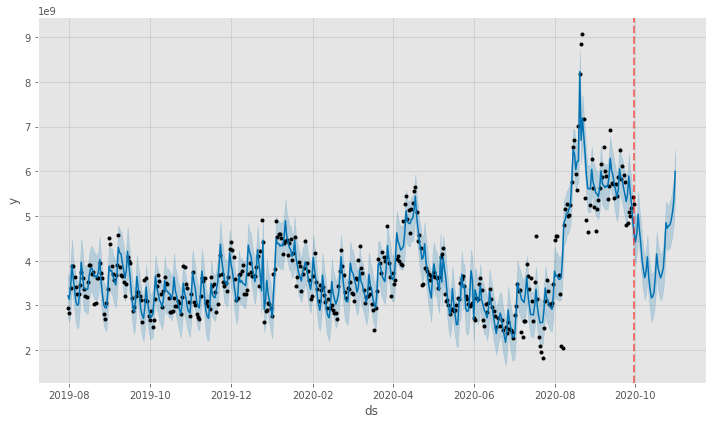

In [ ]:
# Plotting with Prophet built-in method
fig = m.plot(forecast1)
ax = fig.add_subplot(111)
ax.axvline(x=forecast1['ds'].max() - pd.Timedelta('31 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



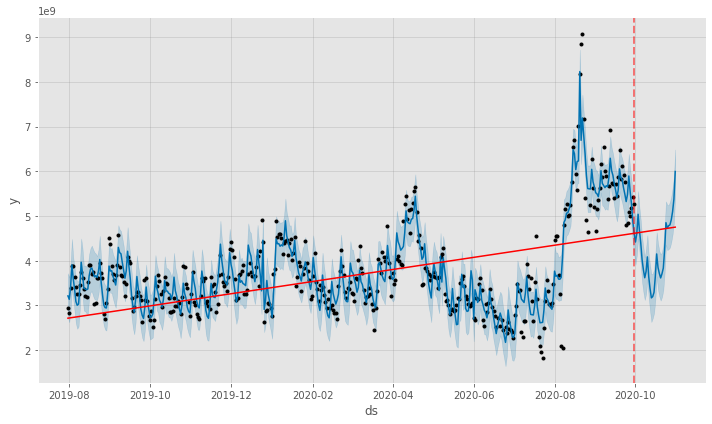

In [ ]:
fig = m.plot(forecast1)
a = add_changepoints_to_plot(fig.gca(), m, forecast1)
ax = fig.add_subplot(111)
ax.axvline(x=forecast1['ds'].max() - pd.Timedelta('31 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [ ]:
# Listing all the change points in the model
deltas = m.params['delta'].mean(0)
cp = pd.DataFrame(m.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6

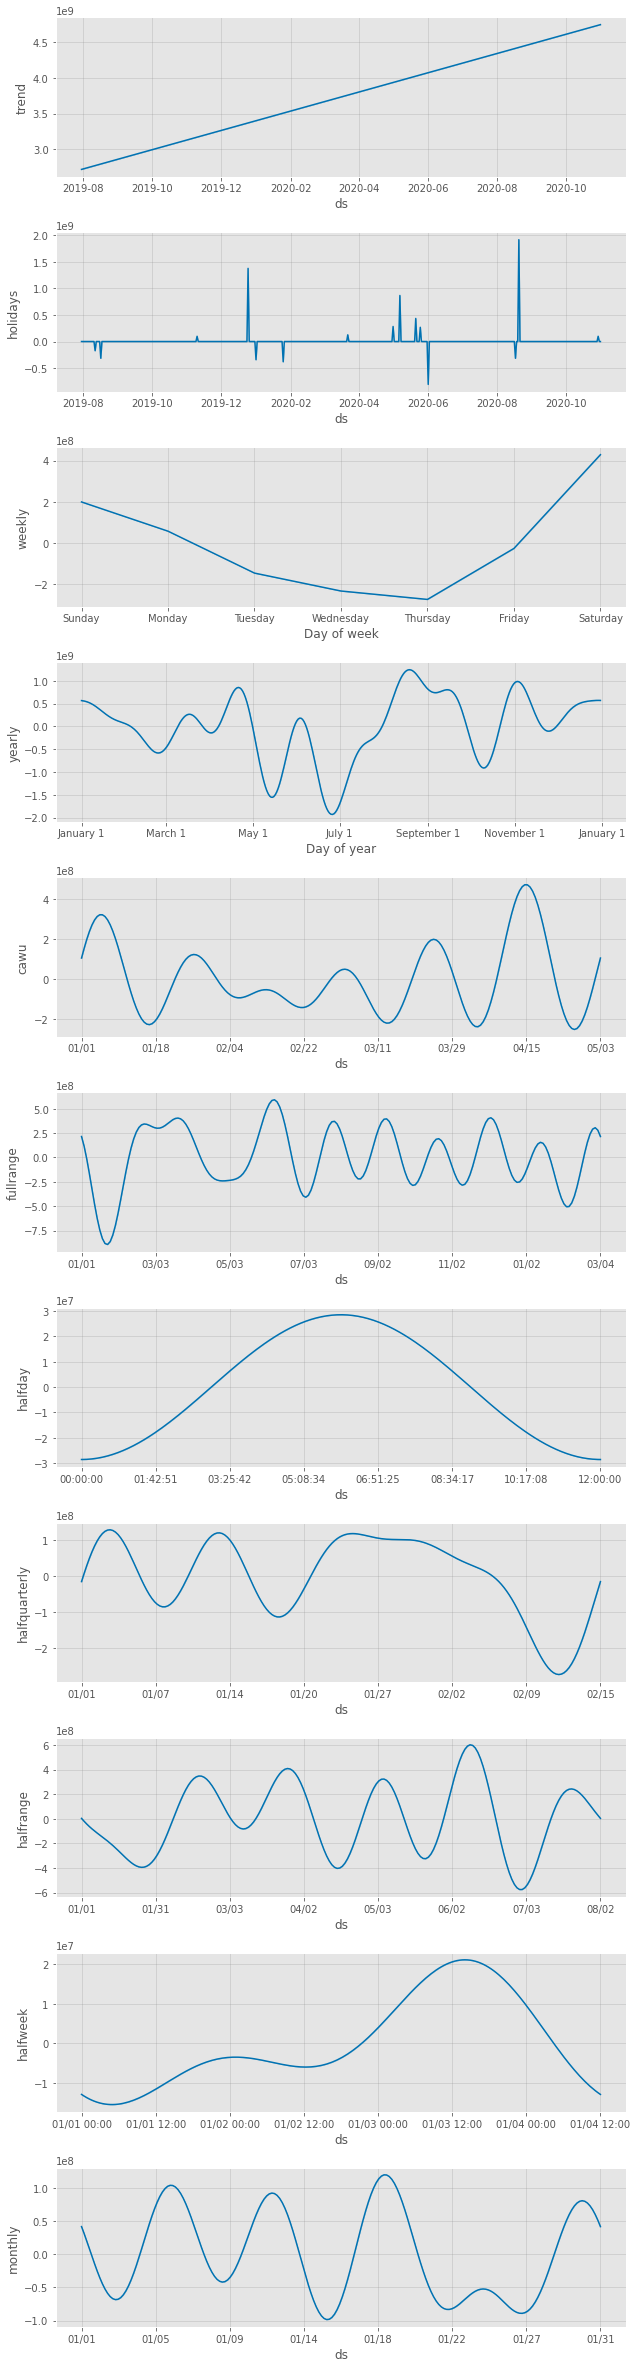

In [ ]:
fig = m.plot_components(forecast1)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



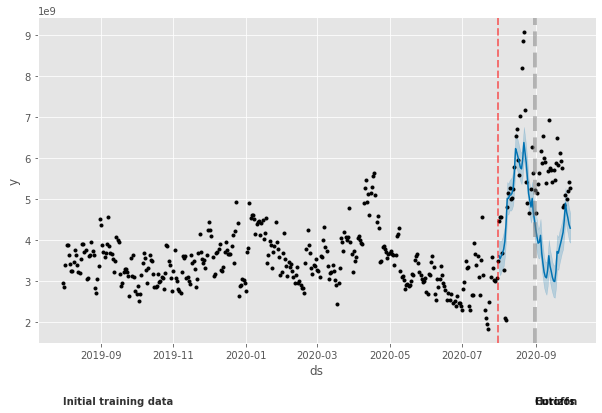

In [ ]:
# Fit the model with one year of data and define a horizon of 31 days forcasting per quarter
df_cv1 = cross_validation(m, initial='366 days', period = '30.5 days', horizon = '61 days')

cutoffs1 = df_cv1.groupby('cutoff').mean().reset_index()['cutoff']
cutoff1 = df_cv1['cutoff'].unique()[0]
df_cv1 = df_cv1[df_cv1['cutoff'].values == cutoff1]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv1['ds'].values, df_cv1['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv1['ds'].values, df_cv1['yhat_lower'],
                df_cv1['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs1:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2019-07-31'),y=12, s='Initial training data', color='black',
       fontsize=10, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2020-08-31'),y=24, s='Cutoffs', color='black',
       fontsize=10, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff1) + pd.Timedelta('31 days'),y=24, s='Horizon', color='black',
       fontsize=10, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff1) + pd.Timedelta('31 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

In [ ]:
df_cv1.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-01,3.614249e+09,3.242138e+09,3.995025e+09,4.470400e+09,2020-07-31
1,2020-08-02,3.538066e+09,3.136707e+09,3.964654e+09,4.554700e+09,2020-07-31
2,2020-08-03,3.611902e+09,3.219615e+09,3.983361e+09,4.562600e+09,2020-07-31
3,2020-08-04,3.667120e+09,3.295920e+09,4.060353e+09,3.673000e+09,2020-07-31
4,2020-08-05,3.776528e+09,3.362891e+09,4.182659e+09,3.255350e+09,2020-07-31


In [ ]:
df_p1 = performance_metrics(df_cv1)
df_p1.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,1.075296e+18,1.036965e+09,8.706621e+08,0.280137,0.199941,0.166667
1,7 days,1.866529e+18,1.366210e+09,1.118141e+09,0.438286,0.215786,0.166667
2,8 days,1.701066e+18,1.304249e+09,9.823518e+08,0.408081,0.184233,0.333333
3,9 days,1.553540e+18,1.246411e+09,8.466751e+08,0.377776,0.101038,0.500000
4,10 days,1.558478e+18,1.248390e+09,8.744018e+08,0.382964,0.101038,0.500000


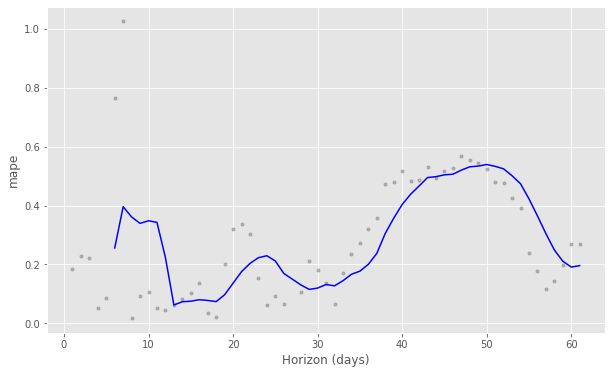

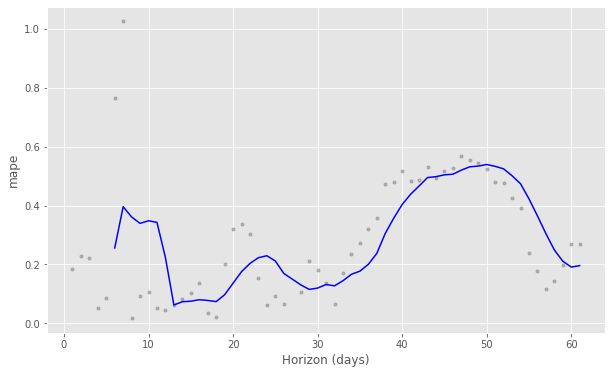

In [ ]:
plot_cross_validation_metric(df_cv1, metric='mape')

In [ ]:
df_p1.mean()

horizon     33 days 14:50:10.909090909
mse                        3.77553e+18
rmse                        1.7171e+09
mae                        1.58775e+09
mape                          0.287011
mdape                          0.26302
coverage                      0.190909
dtype: object

In [ ]:
from sklearn.metrics import mean_squared_log_error
rmsle_channel = sqrt(mean_squared_log_error(df_cv1[['y']],df_cv1[['yhat']]))
print("RMSLE Kas eChannel adalah",rmsle_channel)

RMSLE Kas eChannel adalah 0.13283506754882846


In [ ]:
forecast1[['ds','yhat']].to_csv('submission_channel.csv')

In [ ]:
# Hyperparameters
PERIODS = 31
FREQ = 'D'

# Forecasting
#m = Prophet()
#m = Prophet(weekly_seasonality=True)
#m = Prophet(daily_seasonality=True)
#m = Prophet(yearly_seasonality=True)
#m = Prophet(daily_seasonality=True, weekly_seasonality=True)
#m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.add_country_holidays(country_name='ID')
m.add_seasonality(name='halfday', period=0.5, fourier_order=1, prior_scale=0.05)
m.add_seasonality(name='2day', period=2, fourier_order=2, prior_scale=0.05)
m.add_seasonality(name='halfweek', period=3.5, fourier_order=2, prior_scale=0.05)
m.add_seasonality(name='biweekly', period=15.25, fourier_order=4, prior_scale=0.05)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.05)
m.add_seasonality(name='bimonthly', period=61, fourier_order=5, prior_scale=0.05)
m.add_seasonality(name='halfquarterly', period=45.75, fourier_order=5, prior_scale=0.05)
m.add_seasonality(name='quarterly', period=91.5, fourier_order=6, prior_scale=0.05)
m.add_seasonality(name='semester', period=183, fourier_order=7, prior_scale=0.05)
m.add_seasonality(name='cawu', period=122, fourier_order=6, prior_scale=0.05)
m.add_seasonality(name='cawu2', period=244, fourier_order=8, prior_scale=0.05)
m.add_seasonality(name='fullrange', period=427, fourier_order=10, prior_scale=0.05)
m.add_seasonality(name='halfrange', period=213.5, fourier_order=7, prior_scale=0.05)
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(train_df_masuk_kantor)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future2 = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast2 = m.predict(future2)

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



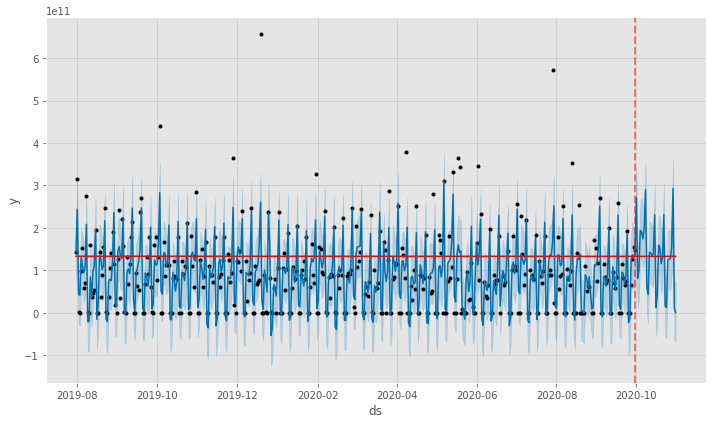

In [ ]:
fig = m.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m, forecast2)
ax = fig.add_subplot(111)
ax.axvline(x=forecast2['ds'].max() - pd.Timedelta('31 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [ ]:
# Hyperparameters
PERIODS = 31
FREQ = 'D'

# Forecasting
m = Prophet()
#m = Prophet(weekly_seasonality=True)
#m = Prophet(daily_seasonality=True)
#m = Prophet(yearly_seasonality=True)
#m = Prophet(daily_seasonality=True, weekly_seasonality=True)
#m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
#m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.add_country_holidays(country_name='ID')
#m.add_seasonality(name='monthly', period=31, fourier_order=3, prior_scale=0.1)
#m.add_seasonality(name='bimonthly', period=62, fourier_order=3, prior_scale=0.1)
#m.add_seasonality(name='quarterly', period=93, fourier_order=3, prior_scale=0.1)
#m.add_seasonality(name='semester', period=180, fourier_order=3, prior_scale=0.1)
m.add_seasonality(name='cawu', period=120, fourier_order=3, prior_scale=0.1)
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(train_df_keluar_kantor)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future3 = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast3 = m.predict(future3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:105: Warning:

We only support Nyepi holiday from 2009 to 2019



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



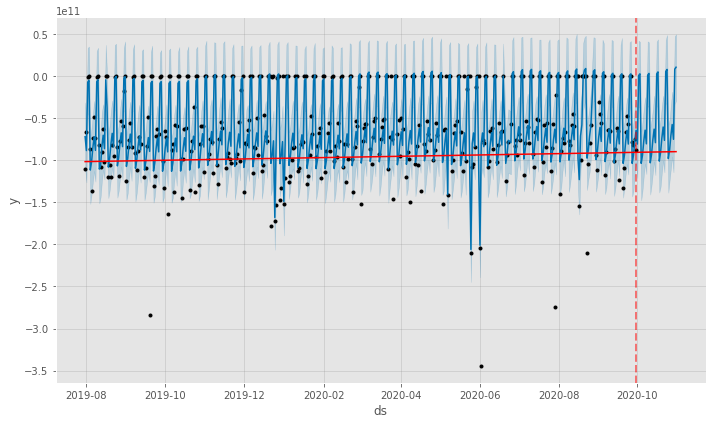

In [ ]:
fig = m.plot(forecast3)
a = add_changepoints_to_plot(fig.gca(), m, forecast3)
ax = fig.add_subplot(111)
ax.axvline(x=forecast3['ds'].max() - pd.Timedelta('31 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [ ]:
# Hyperparameters
PERIODS = 31
FREQ = 'D'

# Forecasting
#m = Prophet()
#m = Prophet(weekly_seasonality=True)
#m = Prophet(daily_seasonality=True)
#m = Prophet(yearly_seasonality=True)
#m = Prophet(daily_seasonality=True, weekly_seasonality=True)
#m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
#m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
#m.add_country_holidays(country_name='ID')
m.add_seasonality(name='monthly', period=31, fourier_order=50, prior_scale=0.1)
m.add_seasonality(name='bimonthly', period=62, fourier_order=50, prior_scale=0.1)
m.add_seasonality(name='quarterly', period=93, fourier_order=50, prior_scale=0.1)
m.add_seasonality(name='semester', period=180, fourier_order=50, prior_scale=0.1)
m.add_seasonality(name='cawu', period=120, fourier_order=50, prior_scale=0.1)
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(train_df_masuk_channel)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future4 = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast4 = m.predict(future4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



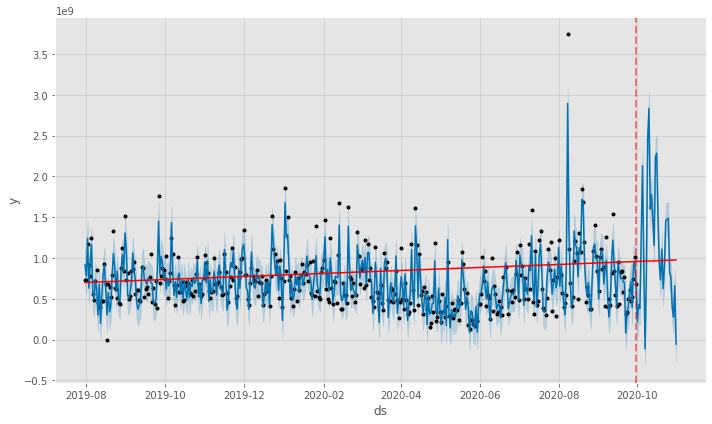

In [ ]:
fig = m.plot(forecast4)
a = add_changepoints_to_plot(fig.gca(), m, forecast4)
ax = fig.add_subplot(111)
ax.axvline(x=forecast4['ds'].max() - pd.Timedelta('31 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [ ]:
# evaluate cnn
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmsle(actual, predicted):
	return sqrt(mean_squared_log_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch = config
	# prepare data
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

In [ ]:
series = train_df_channel
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)